In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
%matplotlib inline 

In [2]:
def get_transformed_mnist_data():
    df = pd.read_csv('../data/mnist/train.csv',header=None)
    data = df.iloc[1:].as_matrix().astype(np.float32)
    Y = data[:,0].astype('int')
    X = data[:,1:]
    mu = X.mean(axis=0)
    X -= mu
    pca = PCA()
    Z = pca.fit_transform(X)
    return Z,Y

In [3]:
def y2indicator(Y):
    N = Y.shape[0]
    K = len(set(Y))
    Y_ind = np.zeros((N,K))
    for i in xrange(N):
        Y_ind[i,Y[i]] = 1
    return Y_ind
def error_rate(targets,predictions):
    return np.mean(targets != predictions)

In [4]:
def display_sample_image(X,Y):
    labels = ["0","1","2","3","4","5","6","7","8","9"]
    X, Y = shuffle(X,Y)
    for i in xrange(12):
        plt.subplot(3,4,i)
        img = X[i].reshape(28,28)
        plt.imshow(img,cmap='gray')
        plt.axis("off")
        plt.title(labels[Y[i]])
    plt.show()

In [5]:
X,Y = get_transformed_mnist_data()

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,2

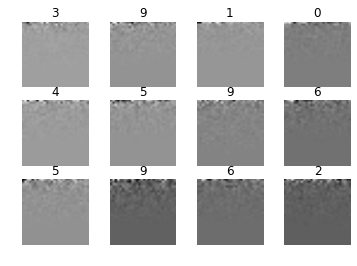

In [6]:
display_sample_image(X,Y)

In [7]:
class NN_batch_gd(object):
    def __init__(self):
        pass
    def train(self,X,Y,learning_rate=1e-8,reg=1e-8,epochs=2000,show_fig=True):
        X_train, T_train = X[:-1000],Y[:-1000]
        X_valid, T_valid = X[-1000:], Y[-1000:]
        T_train_ind = y2indicator(T_train)
        T_valid_ind = y2indicator(T_valid)
        N,D = X_train.shape
        K = len(set(T_train))
        M = 300
        batch_sz = 500
        n_batches = N / batch_sz
        W1_init = np.random.randn(D,M) / np.sqrt(D+M)
        b1_int = np.zeros(M)
        W2_init = np.random.randn(M,K) / np.sqrt(M+K)
        b2_init = np.zeros(K)
        #define theano variables and expressions
        th_X = T.matrix('X')
        th_T = T.matrix('T')
        self.W1 = theano.shared(W1_init,'w1')
        self.b1 = theano.shared(b1_int,'b1')
        self.W2 = theano.shared(W2_init,'w2')
        self.b2 = theano.shared(b2_init,'b2')
        # forwarding 
        th_Z = T.nnet.relu(th_X.dot(self.W1) + self.b1)
        th_Y = T.nnet.softmax(th_Z.dot(self.W2) + self.b2)
        # define the cost expression 
        target = -(th_T * T.log(th_Y)).sum()
#         target = -(th_T * T.log(th_Y)).sum() + \
#                  reg*((self.W1*self.W1).sum() + (self.b1*self.b1).sum() \
#                       + (self.W2*self.W2).sum() (self.b2*self.b2).sum())
        prediction = T.argmax(th_Y,axis=1)
        # update weight expression 
        update_w1 = self.W1 - learning_rate*T.grad(target,self.W1)
        update_b1 = self.b1 - learning_rate*T.grad(target,self.b1)
        update_w2 = self.W2 - learning_rate*T.grad(target,self.W2)
        update_b2 = self.b2 - learning_rate*T.grad(target,self.b2)
        # define the train function for theano 
        train = theano.function(
            inputs=[th_X,th_T],
            updates=[(self.W1,update_w1),(self.b1,update_b1),
                     (self.W2,update_w2),(self.b2,update_b2)]
            
        )
        get_prediction = theano.function(
            inputs=[th_X,th_T],
            outputs=[target,prediction]
        )
        costs = []
        best_validation_error = 1 
        for epoch in xrange(epochs):
            tmp_X, tmp_Y = shuffle(X_train, T_train_ind)
            for j in xrange(n_batches):
                x = tmp_X[j*batch_sz:(j*batch_sz + batch_sz),:]
                y = tmp_Y[j*batch_sz:(j*batch_sz + batch_sz),:]
                train(x,y)
            if epoch % 100 == 0:
                    c, prediction_valid = get_prediction(X_valid,T_valid_ind)
                    costs.append(c)
                    e = error_rate(T_valid,prediction_valid)
                    print "epoch: ",epoch, "cost: ",c, "error: ", e
                    if e < best_validation_error:
                        best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.title('COST')
            plt.show()

In [8]:
# nn_classifier_bgd = NN_batch_gd()
# nn_classifier_bgd.train(X,Y)

## improved the model with batch gradient descent and RAMSprop

In [9]:
class NN_batch_gd_rmsprop(object):
    def __init__(self):
        pass
    def train(self,X,Y,learning_rate=1e-8,reg=1e-8,epochs=2000,show_fig=True):
        X_train, T_train = X[:-1000],Y[:-1000]
        X_valid, T_valid = X[-1000:], Y[-1000:]
        T_train_ind = y2indicator(T_train)
        T_valid_ind = y2indicator(T_valid)
        N,D = X_train.shape
        K = len(set(T_train))
        M = 300
        batch_sz = 500
        n_batches = N / batch_sz
        lr0 = 1e-6 # the initial learning rate 
        decay_rate = 0.999
        eps = 1
        W1_init = np.random.randn(D,M) / np.sqrt(D+M)
        b1_init = np.zeros(M)
        W2_init = np.random.randn(M,K) / np.sqrt(M+K)
        b2_init = np.zeros(K)
        self.W1 = theano.shared(W1_init,'w1')
        self.b1 = theano.shared(b1_init,'b1')
        self.W2 = theano.shared(W2_init,'w2')
        self.b2 = theano.shared(b2_init,'b2')
        #place holder for input matrix and target matrix 
        th_X = T.matrix('X')
        th_T = T.matrix('Y')
        #feedforward
        th_Z = T.nnet.relu(th_X.dot(self.W1) + self.b1)
        th_Y = T.nnet.softmax(th_Z.dot(self.W2) + self.b2)
        #define cost expression and predict expression 
        target = -(th_T*T.log(th_Y)).sum() + reg*((self.W1*self.W1).sum() + \
                (self.b1*self.b1).sum() + (self.W2*self.W2).sum() + (self.b2*self.b2).sum())
        prediction = T.argmax(th_Y,axis=1)
        #adaptive learning rate 
        cache_W2 = theano.shared(np.zeros((M,K)),'cache_W2')
        cache_b2 = theano.shared(np.zeros(K),'cache_b2')
        cache_W1 = theano.shared(np.zeros((D,M)),'cache_W1')
        cache_b1 = theano.shared(np.zeros(M),'cache_b1')
        # update weight expression
        update_cache_W1 = decay_rate*cache_W1 + \
            (1-decay_rate)*T.grad(target,self.W1)*T.grad(target,self.W1)
        update_w1 = self.W1 - lr0*T.grad(target,self.W1)/(T.sqrt(cache_W1) + 1)
        update_cache_b1 = decay_rate*cache_b1 + \
            (1-decay_rate)*T.grad(target,self.b1)*T.grad(target,self.b1)
        update_b1 = self.b1 - lr0*T.grad(target,self.b1)/(T.sqrt(cache_b1) + 1)
        update_cache_W2 = decay_rate*cache_W2 + \
            (1-decay_rate)*T.grad(target,self.W2)*T.grad(target,self.W2)
        update_w2 = self.W2 - lr0*T.grad(target,self.W2)/(T.sqrt(cache_W2) + 1)
        update_cache_b2 = decay_rate*cache_b2 + \
            (1-decay_rate)*T.grad(target,self.b2)*T.grad(target,self.b2)
        update_b2 = self.b2 - lr0*T.grad(target,self.b2)/(T.sqrt(cache_b2) + 1)
        # define the train function for theano 
        train = theano.function(
            inputs=[th_X,th_T],
            updates=[(cache_W1,update_cache_W1),(cache_b1,update_cache_b1),
                    (cache_W2,update_cache_W2),(cache_b2,update_cache_b2),
                    (self.W1,update_w1),(self.b1,update_b1),
                    (self.W2,update_w2),(self.b2,update_b2)]
        )
        get_prediction = theano.function(
            inputs=[th_X,th_T],
            outputs=[target,prediction]
        )
        costs = []
        best_validation_error = 1
        for epoch in xrange(epochs):
            tmp_X, tmp_Y = shuffle(X_train, T_train_ind)
            for j in xrange(n_batches):
                x = tmp_X[j*batch_sz:(j*batch_sz + batch_sz),:]
                y = tmp_Y[j*batch_sz:(j*batch_sz + batch_sz),:]
                train(x,y)
            if epoch % 100 == 0:
                c,y_val = get_prediction(X_valid,T_valid_ind)
                costs.append(c)
                e = error_rate(T_valid,y_val)
                print "epoch: ",epoch, "cost: ",c, "error: ", e
                if e < best_validation_error:
                    best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.title('COST')
            plt.show()

epoch:  0 cost:  29067.1827204 error:  0.708
epoch:  100 cost:  3755.56191872 error:  0.212
epoch:  200 cost:  2239.05601468 error:  0.131
epoch:  300 cost:  1753.0365934 error:  0.112
epoch:  400 cost:  1504.20682857 error:  0.1
epoch:  500 cost:  1376.11210919 error:  0.089
epoch:  600 cost:  1309.93022705 error:  0.083
epoch:  700 cost:  1261.24818806 error:  0.081
epoch:  800 cost:  1229.03381914 error:  0.078
epoch:  900 cost:  1196.19641069 error:  0.077
epoch:  1000 cost:  1161.38574846 error:  0.078
epoch:  1100 cost:  1131.5305314 error:  0.076
epoch:  1200 cost:  1108.80132105 error:  0.074
epoch:  1300 cost:  1093.18818962 error:  0.072
epoch:  1400 cost:  1082.24863249 error:  0.071
epoch:  1500 cost:  1074.06442549 error:  0.07
epoch:  1600 cost:  1067.81258684 error:  0.069
epoch:  1700 cost:  1062.72133223 error:  0.069
epoch:  1800 cost:  1058.43379198 error:  0.068
epoch:  1900 cost:  1054.84801139 error:  0.067
best validation error:  0.067


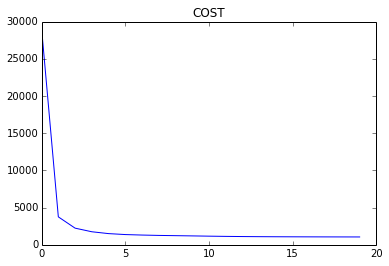

In [10]:
nn_classifier_bgd_rmsprop = NN_batch_gd_rmsprop()
nn_classifier_bgd_rmsprop.train(X,Y)

## improved the model with batch gradient descent rmsprop and dropout

In [11]:
class NN_batch_gd_rmsprop_dropout(object):
    def __init__(self):
        pass
    def train(self,X,Y,learning_rate=1e-8,reg=1e-8,epochs=2000,show_fig=True):
        X_train, T_train = X[:-1000],Y[:-1000]
        X_valid, T_valid = X[-1000:], Y[-1000:]
        T_train_ind = y2indicator(T_train)
        T_valid_ind = y2indicator(T_valid)
        N,D = X_train.shape
        K = len(set(T_train))
        M = 300
        batch_sz = 500
        n_batches = N / batch_sz
        lr0 = 1e-6 # the initial learning rate 
        decay_rate = 0.999
        eps = 1
        self.rng = RandomStreams()
        W1_init = np.random.randn(D,M) / np.sqrt(D+M)
        b1_init = np.zeros(M)
        W2_init = np.random.randn(M,K) / np.sqrt(M+K)
        b2_init = np.zeros(K)
        self.W1 = theano.shared(W1_init,'w1')
        self.b1 = theano.shared(b1_init,'b1')
        self.W2 = theano.shared(W2_init,'w2')
        self.b2 = theano.shared(b2_init,'b2')
        #place holder for input matrix and target matrix 
        th_X = T.matrix('X')
        th_T = T.matrix('Y')
        #feedforward
        th_Y_train = self.forward_train(th_X)
        th_Y_predict = self.forward_predict(th_X)
        #define cost expression and predict expression 
        target = -(th_T*T.log(th_Y_train)).sum()
        prediction = self.predict(th_X)
        cost_predict = -(th_T*T.log(th_Y_predict)).sum()
        #adaptive learning rate 
        cache_W2 = theano.shared(np.zeros((M,K)),'cache_W2')
        cache_b2 = theano.shared(np.zeros(K),'cache_b2')
        cache_W1 = theano.shared(np.zeros((D,M)),'cache_W1')
        cache_b1 = theano.shared(np.zeros(M),'cache_b1')
        # update weight expression
        update_cache_W1 = decay_rate*cache_W1 + \
            (1-decay_rate)*T.grad(target,self.W1)*T.grad(target,self.W1)
        update_w1 = self.W1 - lr0*T.grad(target,self.W1)/(T.sqrt(cache_W1 + 1e-3))
        update_cache_b1 = decay_rate*cache_b1 + \
            (1-decay_rate)*T.grad(target,self.b1)*T.grad(target,self.b1)
        update_b1 = self.b1 - lr0*T.grad(target,self.b1)/(T.sqrt(cache_b1 + 1e-3))
        update_cache_W2 = decay_rate*cache_W2 + \
            (1-decay_rate)*T.grad(target,self.W2)*T.grad(target,self.W2)
        update_w2 = self.W2 - lr0*T.grad(target,self.W2)/(T.sqrt(cache_W2 + 1e-3))
        update_cache_b2 = decay_rate*cache_b2 + \
            (1-decay_rate)*T.grad(target,self.b2)*T.grad(target,self.b2)
        update_b2 = self.b2 - lr0*T.grad(target,self.b2)/(T.sqrt(cache_b2 + 1e-3))
        # define the train function for theano 
        train = theano.function(
            inputs=[th_X,th_T],
            updates=[(cache_W1,update_cache_W1),(cache_b1,update_cache_b1),
                    (cache_W2,update_cache_W2),(cache_b2,update_cache_b2),
                    (self.W1,update_w1),(self.b1,update_b1),
                    (self.W2,update_w2),(self.b2,update_b2)]
        )
        get_prediction = theano.function(
            inputs=[th_X,th_T],
            outputs=[cost_predict,prediction]
        )
        costs = []
        best_validation_error = 1
        for epoch in xrange(epochs):
            tmp_X, tmp_Y = shuffle(X_train, T_train_ind)
            for j in xrange(n_batches):
                x = tmp_X[j*batch_sz:(j*batch_sz + batch_sz),:]
                y = tmp_Y[j*batch_sz:(j*batch_sz + batch_sz),:]
                train(x,y)
            if epoch % 100 == 0:
                c,y_val = get_prediction(X_valid,T_valid_ind)
                costs.append(c)
                e = error_rate(T_valid,y_val)
                print "epoch: ",epoch, "cost: ",c, "error: ", e
                if e < best_validation_error:
                    best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.title('COST')
            plt.show()
    def forward_train(self,X):
        Z = X
        mask = self.rng.binomial(n=1, p=0.8, size=Z.shape)
        Z_mask = mask * Z
        hidden = T.nnet.relu(Z_mask.dot(self.W1) + self.b1)
        return T.nnet.softmax(hidden.dot(self.W2) + self.b2)
    def forward_predict(self,X):
        Z = T.nnet.relu(X.dot(self.W1) + self.b1)
        return T.nnet.softmax(Z.dot(self.W2) + self.b2)
    def predict(self,X):
        P_Y = self.forward_predict(X)
        return T.argmax(P_Y,axis=1)

epoch:  0 cost:  177416.825767 error:  0.613
epoch:  100 cost:  59291.6358687 error:  0.396
epoch:  200 cost:  19565.4882006 error:  0.18
epoch:  300 cost:  9382.30226367 error:  0.122
epoch:  400 cost:  6440.92906895 error:  0.108
epoch:  500 cost:  4837.09061537 error:  0.096
epoch:  600 cost:  3729.41394318 error:  0.087
epoch:  700 cost:  2938.98994152 error:  0.078
epoch:  800 cost:  2388.9418701 error:  0.069
epoch:  900 cost:  1981.67129039 error:  0.066
epoch:  1000 cost:  1668.69450581 error:  0.062
epoch:  1100 cost:  1444.96952328 error:  0.06
epoch:  1200 cost:  1273.85839866 error:  0.055
epoch:  1300 cost:  1131.2797904 error:  0.053
epoch:  1400 cost:  1021.57116103 error:  0.054
epoch:  1500 cost:  943.037119035 error:  0.053
epoch:  1600 cost:  871.221891479 error:  0.052
epoch:  1700 cost:  814.178236523 error:  0.05
epoch:  1800 cost:  767.148018254 error:  0.047
epoch:  1900 cost:  726.759870496 error:  0.048
best validation error:  0.047


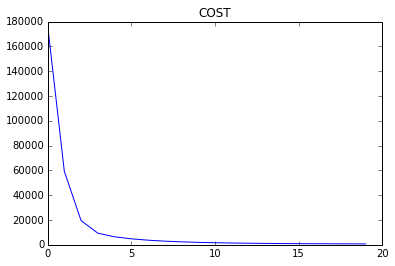

In [12]:
nn_classifier_bgd_rmsprop = NN_batch_gd_rmsprop_dropout()
nn_classifier_bgd_rmsprop.train(X,Y)